# 딥러닝을 이용한 혈액검사

# 0. 데이터셋 준비하기

https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets  
NIH에서 제공한 말라리아 혈액세포 데이터입니다.

## Google Colab

In [ ]:
import os

In [ ]:
# 구글 드라이브 불러오기
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip path_to_file.zip -d path_to_directory
# -u 명령어는 새로운 파일이나 파일이 필요할 경우에만 추출을 제어하는 코드입니다.
# 연결이 끊어져도 사용할 수 있도록 해줍니다
# -d 명령어는 압축을 푼 파일이 저장될곳을 지정합니다.
#!unzip -u "/content/drive/My Drive/cell_images.zip" -d "/content/drive/My Drive/cell_images"

In [ ]:
# 데이터 디렉토리
data_dir = '/content/drive/My Drive/cell_images/cell_images'

In [ ]:
# 데이터 디렉토리의 변수
os.listdir(data_dir)

['test', 'train']

test 폴더와 train 폴더로 나눠져 있습니다.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread # 이미지 파일을 직접 볼 수 있게 해줍니다.

In [ ]:
# 테스트셋과 트레인셋의 디렉토리 설정
test_path = data_dir+'/test/'
train_path = data_dir+'/train/'

## 로컬환경에서 설정

In [ ]:
# 데이터 디렉토리
# cell_images.zip파일 압축 해제 후 폴더의 위치를 적으시면 됩니다.
# data_dir = 'C:\Users\ksh\Downloads\cell_images'

# 테스트셋과 트레인셋의 디렉토리 설정
# test_path = data_dir+'\\test\\'
# train_path = data_dir+'\\train\\'

# 디렉토리 설정이후는 똑같습니다.

In [ ]:
test_path

'/content/drive/My Drive/cell_images/cell_images/test/'

In [ ]:
# test셋 디렉토리의 변수
os.listdir(test_path)

['parasitized', 'uninfected']

In [ ]:
# train셋 디렉토리의 변수
os.listdir(train_path)

['uninfected', 'parasitized']

감염된 혈액(parasitized)의 사진과 감염되지 않은 혈액 (uninfected)의 사진이 다른 폴더로 나뉘어 있습니다.  
감염된 혈액의 사진 하나를 확인해보겠습니다.

In [ ]:
os.listdir(train_path + 'parasitized')[0]

'C97P58ThinF_IMG_20150917_145555_cell_188.png'

In [ ]:
para_cell = train_path + 'parasitized/' + 'C100P61ThinF_IMG_20150918_144104_cell_162.png'
para_cell

'/content/drive/My Drive/cell_images/cell_images/train/parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [ ]:
imread(para_cell).shape # img는 3차원의 튜플, 148 * 142 이미지, rgb채널

(148, 142, 3)

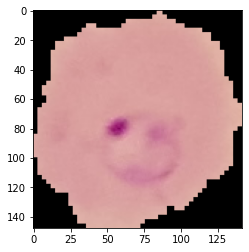

In [ ]:
# plt.imshow를 통해 감염된 혈액세포의 이미지 직접보기
para_img = imread(para_cell)
plt.imshow(para_img)

In [ ]:
os.listdir(train_path + 'uninfected')[0]

'C76P37ThinF_IMG_20150815_172808_cell_155.png'

In [ ]:
uninfect_cell = train_path + 'uninfected/' + 'C100P61ThinF_IMG_20150918_144104_cell_128.png'
uninfect_cell

'/content/drive/My Drive/cell_images/cell_images/train/uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png'

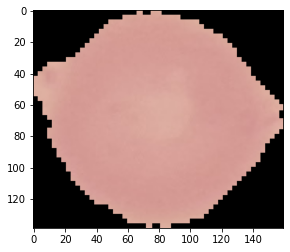

In [ ]:
plt.imshow(imread(uninfect_cell))

정상 혈액과 감염된 혈액의 이미지를 확인해본 결과  
중앙에 보이는 작고 어두운부분으로 감염여부를 확인할 수 있는것 같습니다.

#1. 데이터 전처리

In [ ]:
# tensorflow global random seed 설정
import tensorflow as tf
tf.random.set_seed(3)

import random
random.seed(3)

In [ ]:
print(len(os.listdir(train_path + 'parasitized')))
print(len(os.listdir(train_path + 'uninfected')))
print(len(os.listdir(test_path + 'parasitized')))
print(len(os.listdir(test_path + 'uninfected')))

12480
12480
1300
1300


데이터셋은 클래스별로 12480개, 훈련데이터셋은 클래스 별로 1300개 입니다.  
두 클래스가 균형을 유지하고 있으므로 따로 가중치를 둘 필요는 없어보입니다.

데이터셋 이미지(테스트셋 비감염자 혈액세포)들의 크기를 확인해보겠습니다.

In [ ]:
dim1 = []
dim2 = []

for image_filename in os.listdir(test_path + 'uninfected'):
  img = imread(test_path + 'uninfected/'+image_filename) # img는 3차원의 튜플
  d1, d2, colors = img.shape
  dim1.append(d1)
  dim2.append(d2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


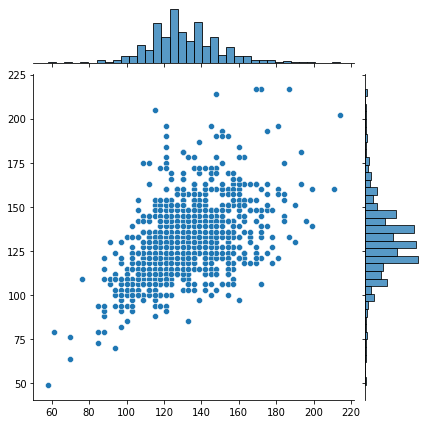

In [ ]:
sns.jointplot(dim1,dim2)

데이터셋은 0 ~ 255사이의 크기의 이미지 파일로 똑같은 크기가 아니라 다양한 크기로 이루어져 있기 때문에  
이미지 사이즈를 똑같이 만들어주는 전처리과정이 필요합니다.

In [ ]:
print(np.mean(dim1))
print(np.mean(dim2))

130.92538461538462


130.75

너비와 높이를 확인해본결과 데이터셋을 이루는 이미지의 평균 사이즈는 130*130 이므로

이 사이즈에 맞춰서 전처리해주겠습니다. 

In [ ]:
# 이미지 사이즈 고정, 이후 모델 input_shape로 설정
image_shape = (130,130,3)

In [ ]:
imread(para_cell)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [ ]:
print(imread(para_cell).max())
print(imread(para_cell).min())

0.9098039
0.0


이미지의 크기(영역)는 0~255로 다양해서 resize는 필요했지만,

이미지의 픽셀은 0~1사이로 정규화 되어있으므로 normalizing은 필요하지 않습니다.



하지만 우리가 가진 데이터셋의 이미지는 30000개 미만이고, 감염여부로 나뉜 train set은 12000개입니다.  
모델이 학습하기에는 부족한 데이터 수이므로 Image Manipulation을 해주겠습니다.

## Image augmentation

회전, 이동, 변형, 확대, 축소 뒤집기 등을 통해서 데이터의 수를 늘려주는 작업입니다.  
아래는 imageDataGenerator의 각 파라미터에 대한 설명을 이미지로 나타낸 사이트입니다.  
https://tykimos.github.io/2017/06/10/CNN_Data_Augmentation/

In [ ]:
# Image Manipulation를 위해 keras 내장함수 ImageDataGenerator를 사용하겠습니다.
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator()

In [ ]:
# 아래 모든값들은 최대를 뜻하는데 width_shift_range=0.10 인경우 0~10% 내외로 변경한다는걸 의미합니다.
image_gen = ImageDataGenerator(rotation_range=20, # 이미지를 최대 20도 만큼 회전 
                               width_shift_range=0.10, # 최대 10% 너비 변경 
                               height_shift_range=0.10, # 최대 10% 높이 변경
                               # rescale=1/255, # 이미지 정규화 
                               shear_range=0.1, # 반시계 방향으로 층을 밀어줍니다.(그림으로 확인)
                               zoom_range=0.1, # 최대 10% 확대합니다.
                               horizontal_flip=True, # 인풋을 무작위로 가로로 뒤집습니다.
                               fill_mode='nearest' # 빈 픽셀을 가장 가까운 픽셀값으로 채웁니다.
                              )

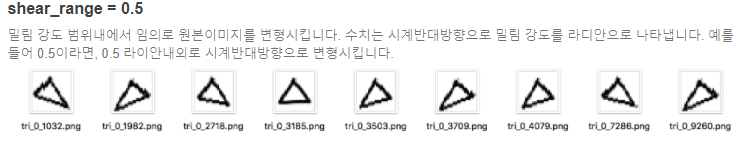

ImageDataGenerator는 batch size만큼 데이터를 만들어냅니다.

예를 들어 batch size가 32인 경우 한 이미지를 파라미터의 조건에 따라 32개의 이미지로 만들어냅니다.

이미지 데이터는 다른 텍스트 데이터에 비해 많은양을 보유하기 힘듭니다.﻿



그래서 Image augmentation으로 이미지의 양을 늘려서 모델이 충분한 학습을 하게 해줍니다.

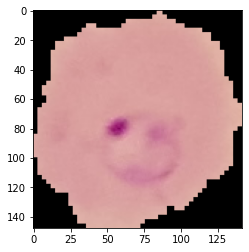

In [ ]:
# 감염된 혈액세포 이미지의 원본
plt.imshow(para_img) # para_img = imread(para_cell)

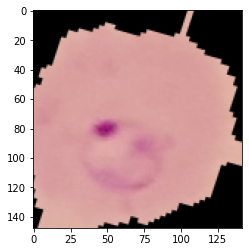

In [ ]:
# ImageDataGenerator()를 거친 이미지
plt.imshow(image_gen.random_transform(para_img))

툭 튀어나온 기둥같은 모양은 ImageDataGenerator를 거치면서 이미지가 변형되는 과정속에서 이미지가 뻗어 나갔고,  fill_mode를 통해 주변 이미지가 채워진것입니다.

이제 모든 데이터셋을 ImageDataGenerator를 통해 늘려보겠습니다.

In [ ]:
train_path

'/content/drive/My Drive/cell_images/cell_images/train/'

In [ ]:
# train 폴더에 있는 이미지들을 모두 ImageDataGenerator를 통해 이미지 변형을 해주겠습니다.
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [ ]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


Found 24958 images belonging to 2 classes의 의미는 우리가 사용하는 train set폴더 안에서  
'parasitized', 'uninfected' 폴더로 나누어져 있기 때문에 정상적으로 작동했다고 이해하시면 됩니다.  
(만약 5가지 class로 나뉘어 있다면 images belonging to 5 classes 라는 문구가 떠야됩니다.)

#2. 모델 생성

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu')) # image_shape = (130,130,3)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

# 학습중 과적합을 줄여주는 dropout 추가, dropout은 무작위로 뉴런의 일부를 사용하지 않는 기능을 합니다.
model.add(Dropout(0.5)) # 랜덤하게 50%의 뉴런을 사용하지 않습니다.

# 이진분류 모델이기 때문에 Dense = 1이고, sigmoid 함수를 마지막 아웃풋 레이어에 사용합니다.
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# patience 는 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 정의한다.
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=2)

In [ ]:
# 로컬에서도 돌려보기 위해서 배치사이즈를 크게 설정햇고, colab에서는 tpu가 8코어이기 때문에 배치사이즈를 8의 배수로 설정하는게 일반적이라고 합니다.
# 훈련 데이터 수가 클래스당 12000개이니 배치 크기를 256으로 지정하여 
# 49번 배치(총 98번)를 수행하면 하나의 epoch가 수행될 수 있도록 하였습니다.

batch_size = 256

In [ ]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='binary') # 이진분류 모델이기 때문에

Found 24958 images belonging to 2 classes.


target_size=image_shape[:2]는 image_shape = (130,130,3)에서 130*130만 쓰기 때문에 [:2]로 잘라준것입니다.  


In [ ]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


train set은 무작위로 섞어도 되지만, test set은 섞이면 안됩니다.  
라벨이 실제 특성과 다르게 섞여버리기 때문

In [ ]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

감염된 혈액세포를 0으로, 정상 혈액세포를 1로 구분

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
results = model.fit_generator(train_image_gen, epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
98/98 [==============================] - 139s 1s/step - loss: 0.6610 - accuracy: 0.6094 - val_loss: 0.6568 - val_accuracy: 0.6065
Epoch 2/20
98/98 [==============================] - 139s 1s/step - loss: 0.6547 - accuracy: 0.6240 - val_loss: 0.6575 - val_accuracy: 0.6269
Epoch 3/20
98/98 [==============================] - 139s 1s/step - loss: 0.6394 - accuracy: 0.6394 - val_loss: 0.4924 - val_accuracy: 0.7858
Epoch 4/20
98/98 [==============================] - 139s 1s/step - loss: 0.2932 - accuracy: 0.8985 - val_loss: 0.2332 - val_accuracy: 0.9158
Epoch 5/20
98/98 [==============================] - 138s 1s/step - loss: 0.2494 - accuracy: 0.9161 - val_loss: 0.2286 - val_accuracy: 0.9212
Epoch 6/20
98/98 [==============================] - 139s 1s/step - loss: 0.2319 - accuracy: 0.9230 - val_loss: 0.1978 - val_accuracy: 0.9319
Epoch 7/20
98/98 [==============================] - 138s 1s/step - loss: 0.1968 - accuracy: 0.9333 - val_loss: 0.1957 - val_accuracy: 0.9223
Epoch 8/20
98

In [ ]:
norm_losses = pd.DataFrame(model.history.history)

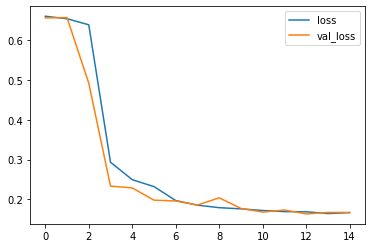

In [ ]:
norm_losses[['loss','val_loss']].plot()

모델의 히스토리를 확인해본 결과 학습이 완료된 모델은 과적합이나 학습률 문제는 없는것으로 보입니다.

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
model.evaluate_generator(test_image_gen)

[0.1508789211511612, 0.944615364074707]

정확도가 94.4%가 나온걸로 봐선 모델의 성능 또한 준수하게 나온걸 확인할 수 있습니다.

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
pred_probabilities = model.predict_generator(test_image_gen)

In [ ]:
pred_probabilities

array([[3.1565380e-04],
       [6.1449515e-05],
       [1.3519489e-04],
       ...,
       [9.7180068e-01],
       [9.7083414e-01],
       [9.3442720e-01]], dtype=float32)

In [ ]:
# 50% 이상의 확률
predictions = pred_probabilities > 0.5

In [ ]:
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

정상 혈액세포를 True로 감염된 혈액세포를 False로 구분

확률을 default 값인 50%와 높은 기준인 90%로 두가지로 나누어 성능을 비교해보겠습니다.

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
# 임계값이 0.5
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1300
           1       0.93      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [ ]:
# 임계값이 0.9
predictions_90 = pred_probabilities > 0.9
print(classification_report(test_image_gen.classes, predictions_90))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1300
           1       0.97      0.81      0.88      1300

    accuracy                           0.89      2600
   macro avg       0.90      0.89      0.89      2600
weighted avg       0.90      0.89      0.89      2600



정밀도(precision)란 모델이 True라고 분류한 것 중에서 실제 True인 것의 비율입니다.  
재현율(recall)이란 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율입니다.


pred_probabilities를 0.9 (90%)로 설정했을때 0.5(50%)인 경우보다 0(감염자)의 recall이 높습니다.  
pred_probabilities에 따라 다른 성능이 나오는 특성은 다양하게 사용될 수 있습니다.



예를 들어 환자의 혈액검사를 진행하는 의사입장에서 고민해봅시다.  
치사율이 낮은 병에 대해서 혈액검사를 진행하는데 복용하는 약의 부작용이 걱정된다면  
pred_probabilities를 0.5로 설정해서 정밀도를 높인 검사를 진행하는게 맞겠지만  
말라리아같은 치사율이 높은 병을 검사한다면 pred_probabilities를 0.9로 설정해서 재현율을 높일 것 같습니다.

# Cross Validation

Cross Validation을 수행하기 위해서는 data set을 ImageDataGenerator으로 설정해서는 안됩니다.  
아직 ImageDataGenerator을 사용해서 데이터셋을 구분하는 기능이 구현되지 않았기 때문입니다.

데이터 로드속도가 너무 오래걸려서 테스트셋의 이미지만 불러와서 사용하겠습니다.

In [ ]:
import skimage
import numpy as np
from skimage import color, io
from skimage.transform import resize

In [ ]:
test_path

'/content/drive/My Drive/cell_images/cell_images/test/'

In [ ]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [ ]:
X_parasite = skimage.io.imread_collection('/content/drive/My Drive/cell_images/cell_images/test/parasitized/*.png')
X_uninfect = skimage.io.imread_collection('/content/drive/My Drive/cell_images/cell_images/test/uninfected/*.png')

In [ ]:
# 데이터의 양
print(len(X_parasite))
print(len(X_uninfect))

1300
1300


In [ ]:
# 데이터의 형태
print(X_parasite[0].shape)
print(X_uninfect[0].shape)

(112, 148, 3)
(136, 157, 3)


이전에는 generator를 이용해서 image resize와 labeling을 해줬지만  
이번에는 교차검증을 위해  imread를 사용하기 때문에 수동적인 전처리과정이 필요합니다.

In [ ]:
# resize
X_parasite = [resize(img, (130, 130)) for img in X_parasite]
X_uninfect = [resize(img, (130, 130)) for img in X_uninfect]

In [ ]:
# labeling
# 기존 데이터와 같이 감염자의 혈액을 0, 비감염자의 혈액을 1로 설정
y_parasite = np.zeros(len(X_parasite)) # np.array([0] * len(X_parasite))
y_uninfect = np.ones(len(X_uninfect)) # np.array([1] * len(X_uninfect))

In [ ]:
# 두 데이터셋 합치기
X_cv = np.concatenate((X_parasite, X_uninfect))
y_cv = np.concatenate((y_parasite, y_uninfect))

모델 선언 함수 (기존 모델과 같습니다.)

In [ ]:
# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
	# compile model
  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  return model

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

kf = kfold.get_n_splits(X)
cvscores = []

#for each train, test in cross validation sub-set
for train, test in kfold.split(X_cv, y_cv):

    X_train, X_test = X_cv[train], X_cv[test]
    y_train, y_test = y_cv[train], y_cv[test]

    #add layers to model
    model = define_model()

    #monitor val accuracy and perform early stopping
    early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=2)

    #fit the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[early_stop], epochs=20, batch_size=32)

    #evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

Epoch 1/20
65/65 [==============================] - 2s 27ms/step - loss: 0.7008 - accuracy: 0.5189 - val_loss: 0.6812 - val_accuracy: 0.5365
Epoch 2/20
65/65 [==============================] - 1s 23ms/step - loss: 0.6653 - accuracy: 0.6134 - val_loss: 0.6054 - val_accuracy: 0.7250
Epoch 3/20
65/65 [==============================] - 1s 23ms/step - loss: 0.6188 - accuracy: 0.6907 - val_loss: 0.5684 - val_accuracy: 0.7038
Epoch 4/20
65/65 [==============================] - 1s 23ms/step - loss: 0.4843 - accuracy: 0.8125 - val_loss: 0.3151 - val_accuracy: 0.8981
Epoch 5/20
65/65 [==============================] - 1s 23ms/step - loss: 0.3313 - accuracy: 0.8878 - val_loss: 0.2810 - val_accuracy: 0.9038
Epoch 6/20
65/65 [==============================] - 1s 23ms/step - loss: 0.2813 - accuracy: 0.9076 - val_loss: 0.3447 - val_accuracy: 0.8596
Epoch 7/20
65/65 [==============================] - 1s 23ms/step - loss: 0.2150 - accuracy: 0.9265 - val_loss: 0.2483 - val_accuracy: 0.9115
Epoch 8/20
65

In [ ]:
#check the accuracy
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

92.50% (+/- 1.21%)


기존 모델의 정확도인 94.4%보다 조금 낮아진 정확도입니다.  
기존 모델은 교차검증할때 사용한 데이터셋 보다 더 많은 데이터를 사용했고,  
ImageDataGenerator를 써서 Image argumatation까지 사용했기 떄문에 더 좋은 정확도가 나왔다고 생각합니다. 

# 이미지를 보고 예측해보기

train set의 100번째 이미지를 불러와서 모델이 어떻게 예측하는지 살펴보겠습니다.

In [ ]:
os.listdir(train_path + 'parasitized')[100]

'C99P60ThinF_IMG_20150918_140900_cell_105.png'

In [ ]:
para_cell_100 = train_path + 'parasitized/' + 'C99P60ThinF_IMG_20150918_140900_cell_105.png'

In [ ]:
my_image = image.load_img(para_cell_100,target_size=image_shape)

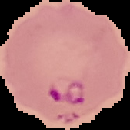

In [ ]:
my_image

In [ ]:
my_image = np.expand_dims(my_image, axis=0)

In [ ]:
model.predict(my_image)

array([[0.]], dtype=float32)

모델의 예측은 감염자(0)으로 예측하고 있고, 올바른 예측입니다.  

In [ ]:
os.listdir(train_path + 'uninfected')[100]

'C87P48ThinF_IMG_20150820_132642_cell_160.png'

In [ ]:
uninf_cell_100 = train_path + 'uninfected/' + 'C87P48ThinF_IMG_20150820_132642_cell_160.png'

In [ ]:
my_image_1 = image.load_img(uninf_cell_100,target_size=image_shape)

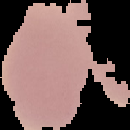

In [ ]:
my_image_1

In [ ]:
my_image_1 = np.expand_dims(my_image_1, axis=0)

In [ ]:
model.predict(my_image_1)

array([[1.]], dtype=float32)

비감염자의 혈액세포 또한 모델이 올바르게 예측하고 있는걸 확인할 수 있습니다.

# requirements.txt 파일 만들기

In [ ]:
!pip freeze > requirements.txt